In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import Pipeline

from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectPercentile

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

print('The Matplotlib version is {}.\n'.format(mpl.__version__))
mpl.rcParams['figure.dpi'] = 400 

The Matplotlib version is 3.3.4.



# Examining relationships between features and response variable

In [2]:
df = pd.read_csv('data/df_clean_2.csv')

In [3]:
# create a list of the columns
features_response = df.columns.to_list()

# we create a list of items to remove 
to_remove = ['ID', 'SEX', 'EDUCATION_CAT', 'PAY_2','PAY_3','PAY_4','PAY_5','PAY_6',
             'graduate school','high school','others','university']

# upadated feature response
features_response = [item for item in features_response if item not in to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

## Pearson Correlation

<AxesSubplot:>

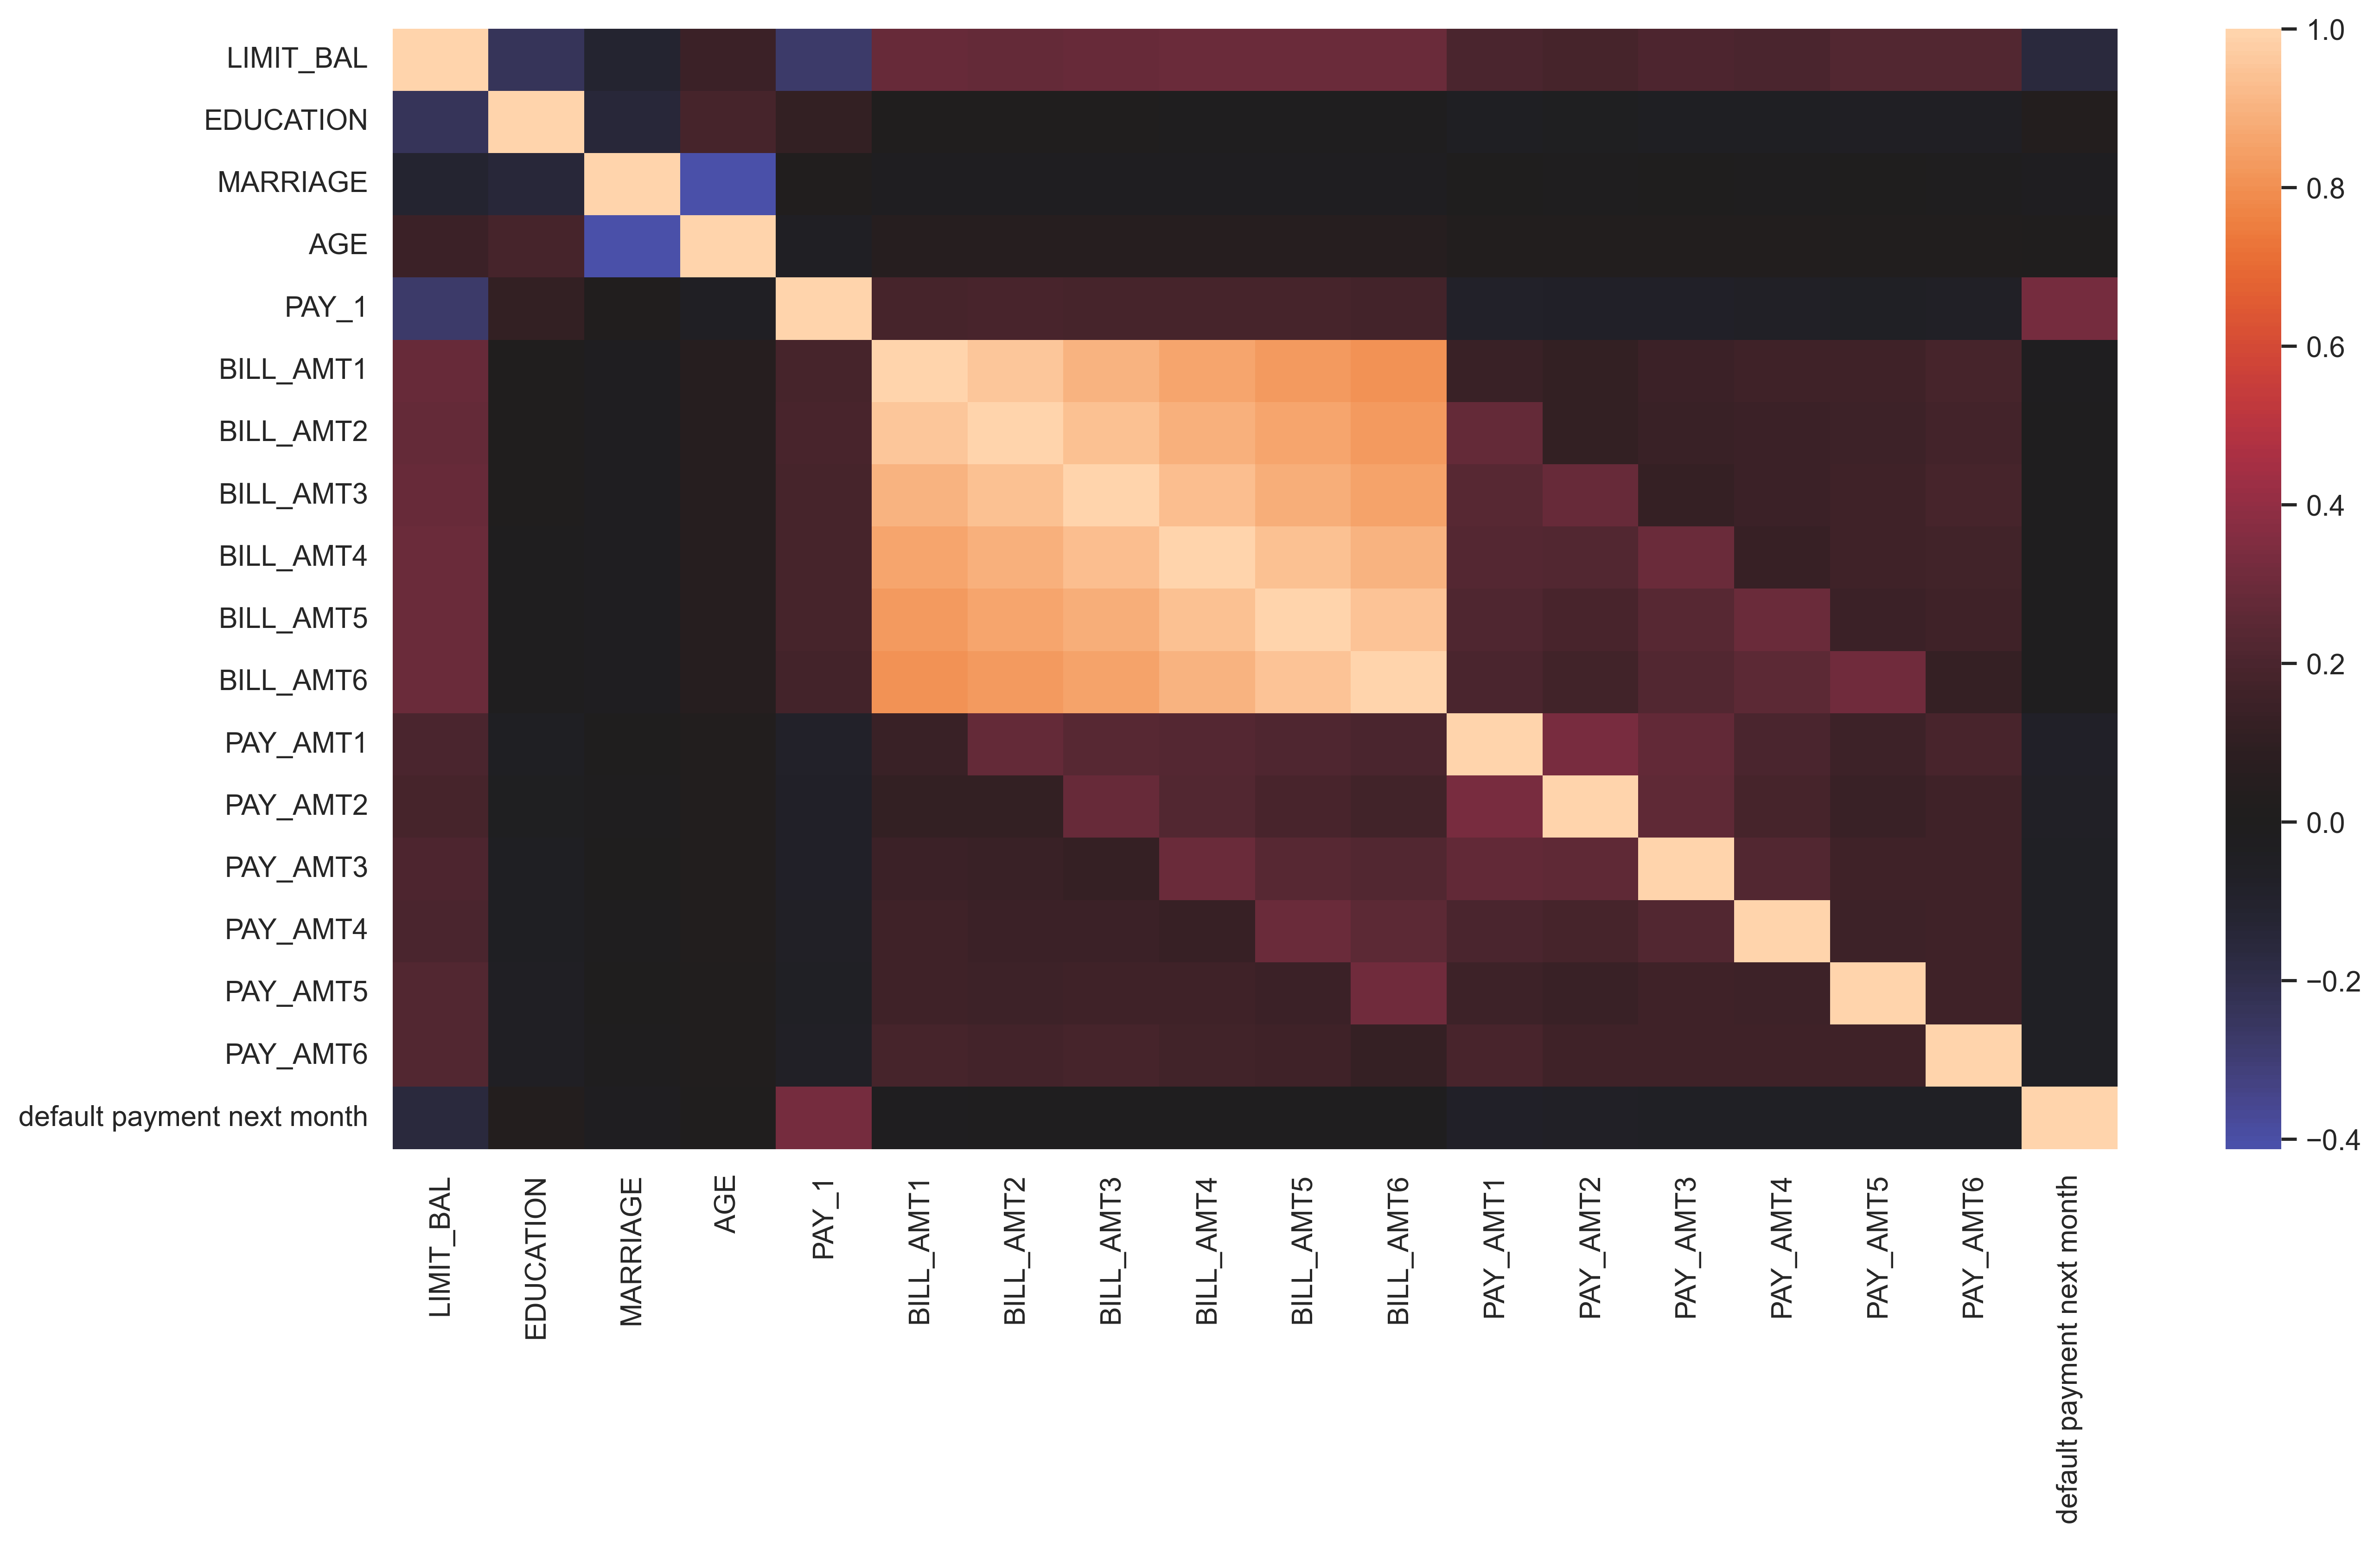

In [4]:
corr = df[features_response].corr()
sns.set(rc={'figure.figsize': (15,8)})
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, center=0)

Here we see that the PAY_1 feature is probably the most strongly correlated feature to the response variable.
The other feature that looks like itmay be important is LIMIT_BAL , which is negatively correlated.

## F-test and Univariate Feature Selection

In [5]:
# seprate out the features and responses
X = df[features_response].iloc[:, :-1]
y = df[features_response].iloc[:, -1]
print(X.shape, y.shape)

(26664, 17) (26664,)


In [8]:
[f_stat, f_p_value] = f_classif(X, y)
f_df = pd.DataFrame({'Feature':features_response[:-1],'F statistic':f_stat,'p value':f_p_value})
f_df.sort_values('p value')

,Feature,F statistic,p value
4,PAY_1,3156.672300,0.000000e+00
0,LIMIT_BAL,651.324071,5.838366e-142
11,PAY_AMT1,140.612679,2.358354e-32
12,PAY_AMT2,101.408321,8.256124e-24
13,PAY_AMT3,90.023873,2.542641e-21
15,PAY_AMT5,85.843295,2.090120e-20
16,PAY_AMT6,80.420784,3.219565e-19
14,PAY_AMT4,79.640021,4.774112e-19
1,EDUCATION,32.637768,1.122175e-08
2,MARRIAGE,18.078027,2.127555e-05


The conclusions we can draw from the DataFrame of F-statistics and p-values are similar to what we observed in the correlation plot: PAY_1 and LIMIT_BAL appear to be the most useful features. They have the smallest p-values, indicating the average values of these features are significantly different between the positive and negative classes, and these features will help predict which class a sample belongs to.

In [9]:
selector = SelectPercentile(f_classif, percentile=20)
selector.fit(X,y)
best_feature_ix = selector.get_support()
best_feature_ix

array([ True, False, False, False,  True, False, False, False, False,
       False, False,  True,  True, False, False, False, False])

In [10]:
features = features_response[:-1]
best_features = [features[i] for i in range(len(features)) if best_feature_ix[i]]
best_features

['LIMIT_BAL', 'PAY_1', 'PAY_AMT1', 'PAY_AMT2']

## Visualizing Feature-Response Relationship

### PAY_1

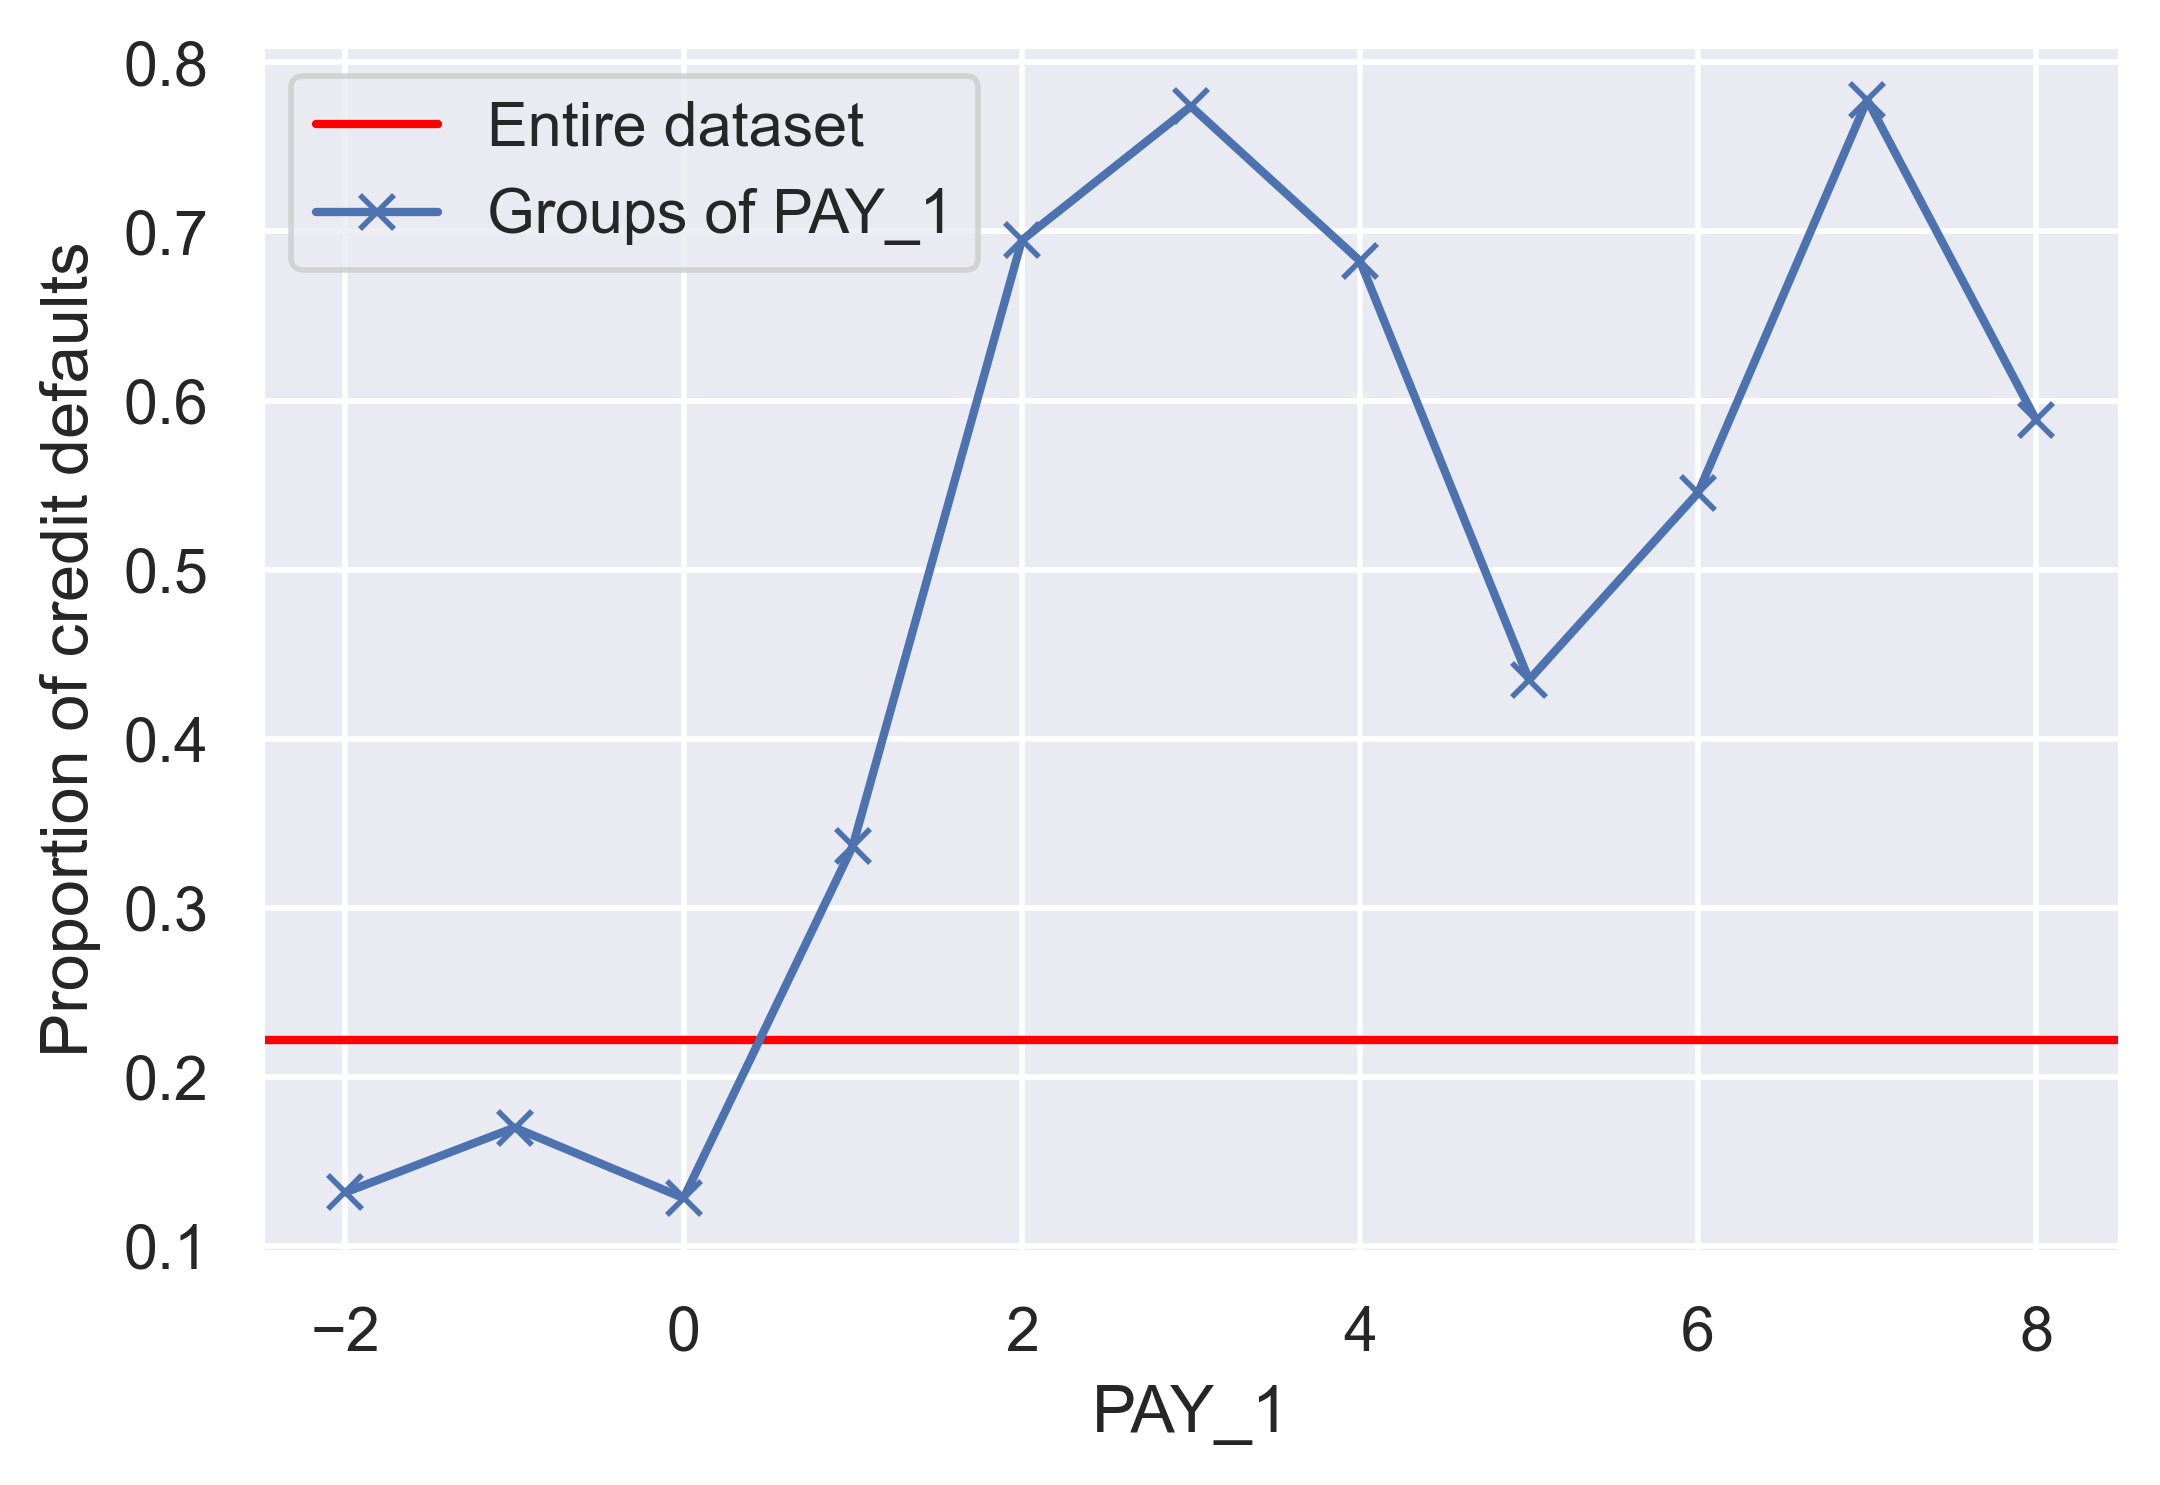

In [12]:
# calcualte default rate across the whole dataset
default_rate = df['default payment next month'].mean()

# visualizing default rates for different values of PAY_1
pay_default_rates = df.groupby('PAY_1').agg({'default payment next month': np.mean})

axes = plt.axes()
axes.axhline(default_rate, color='red')
pay_default_rates.plot(marker='x', legend=False, ax=axes)
axes.set_ylabel('Proportion of credit defaults')
axes.legend(['Entire dataset', 'Groups of PAY_1'])

Those who defaulted before are in fact more likely to default again. The default rate of accounts in good standing is well below the overall default rate, which we know from before is about 22%.

### LIMIT_BAL

Text(0.5, 1.0, 'Credit limits by response variable')

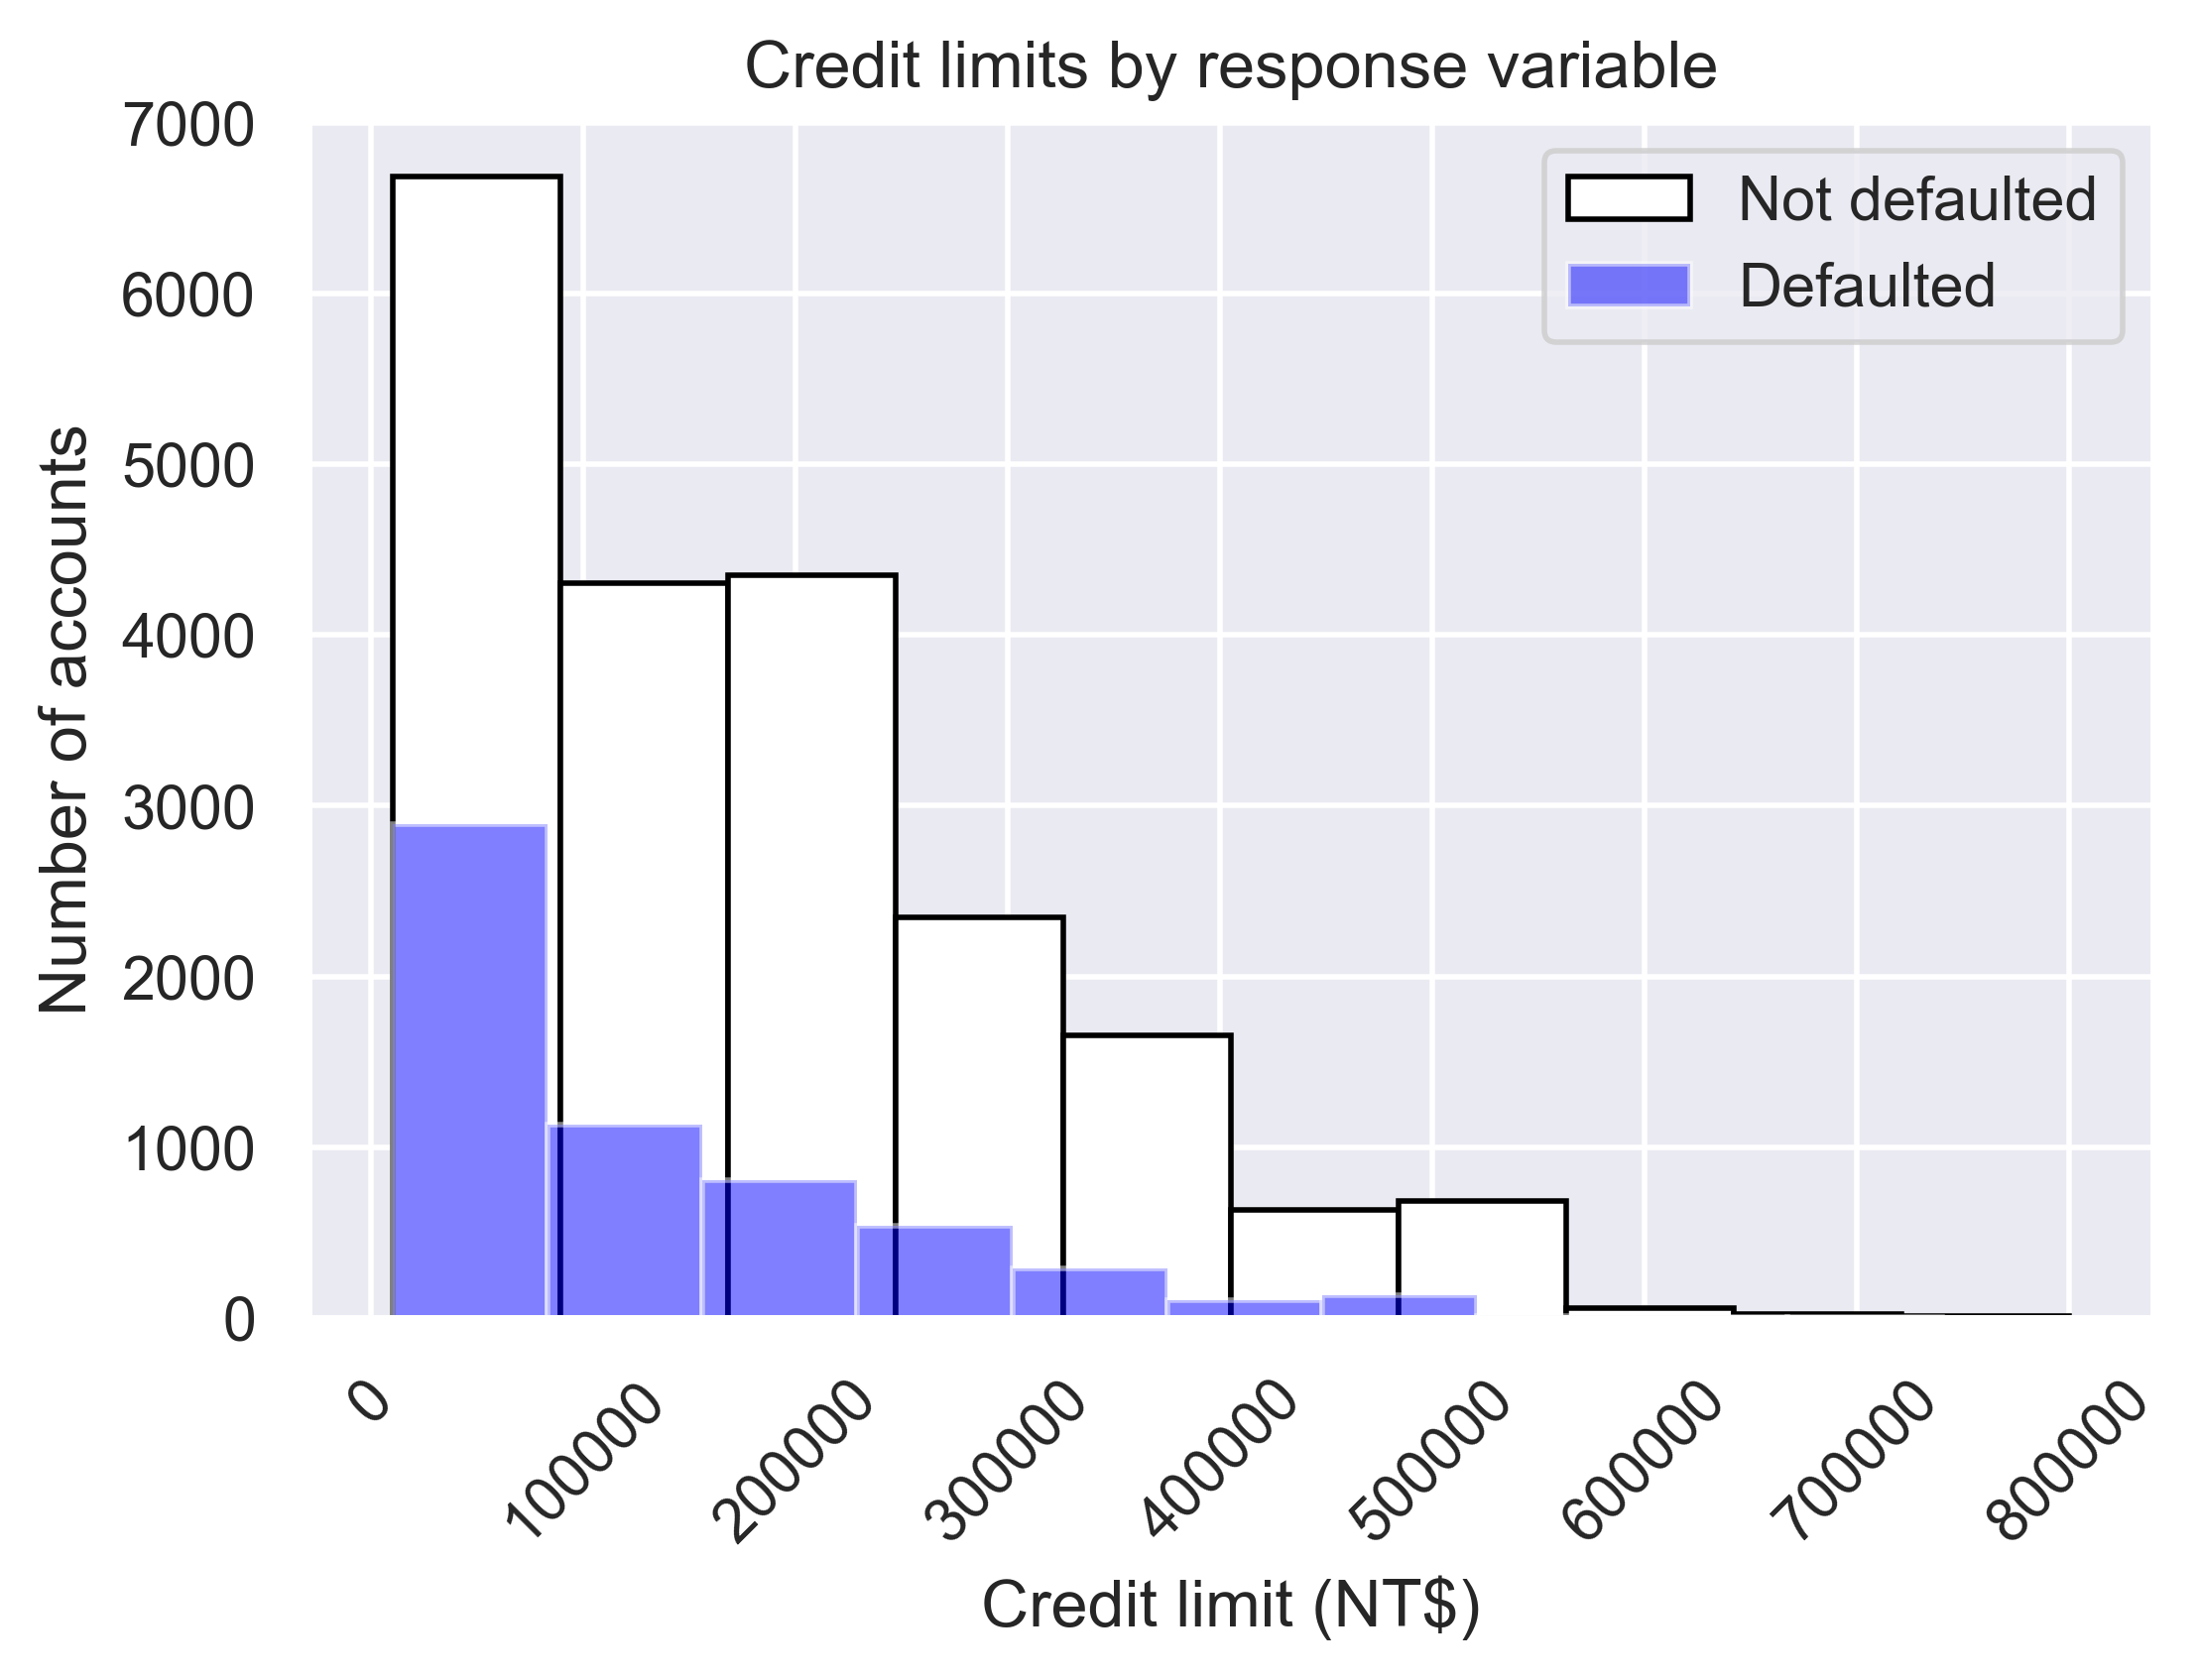

In [13]:
# create masks for positive and negative samples
pos_mask = y == 1
neg_mask = y == 0

axes = plt.axes()
axes.hist(df.loc[neg_mask, 'LIMIT_BAL'],edgecolor='black', color='white')
axes.hist(df.loc[pos_mask, 'LIMIT_BAL'],alpha=0.5, edgecolor=None, color='blue')
axes.tick_params(axis='x', labelrotation=45)
axes.set_xlabel('Credit limit (NT$)')
axes.set_ylabel('Number of accounts')
axes.legend(['Not defaulted', 'Defaulted'])
axes.set_title('Credit limits by response variable')

In [14]:
# normalizing the histograms
df['LIMIT_BAL'].max()
bin_edges = list(range(0,850000,50000))
print(bin_edges)

[0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000]


/tmp/ipykernel_10388/779883196.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(np.round(y_ticks*50000,2))


Text(0.5, 1.0, 'Normalized distributions of credit limits by response variable')

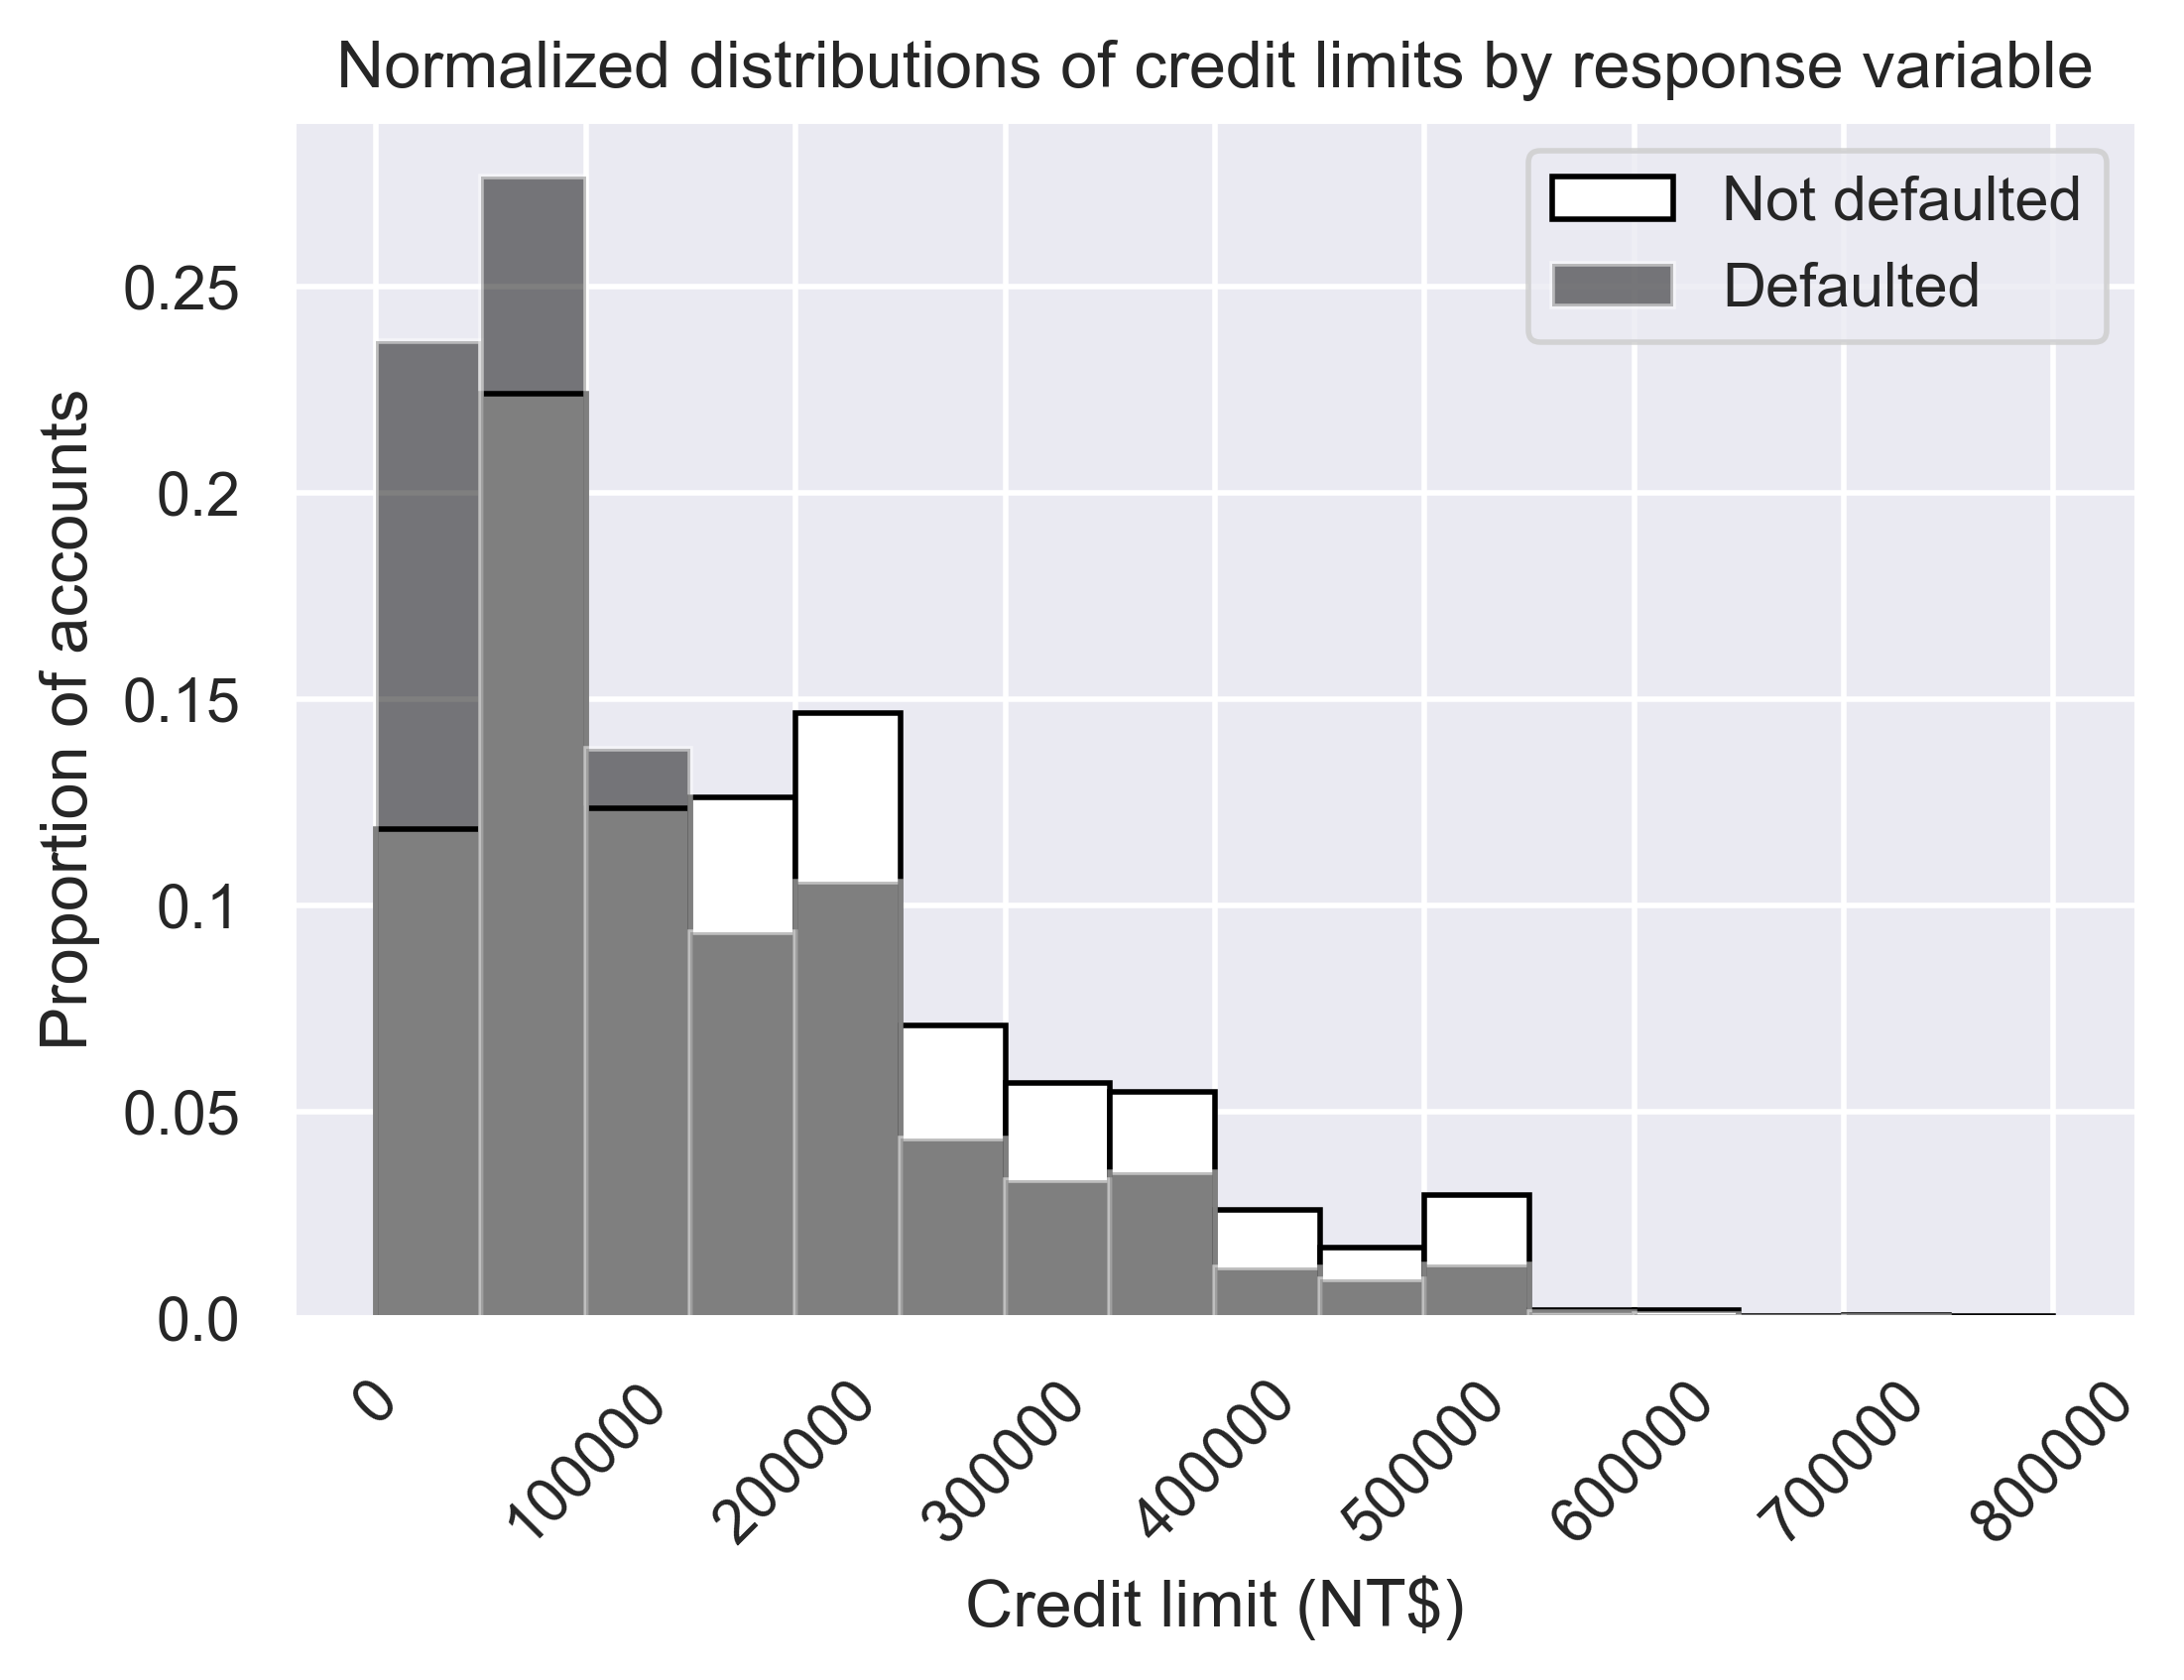

In [15]:
axes = plt.axes()

axes.hist(df.loc[neg_mask, 'LIMIT_BAL'], bins=bin_edges, density=True, edgecolor='black', color='white')
axes.hist(df.loc[pos_mask, 'LIMIT_BAL'], bins=bin_edges, density=True, alpha=0.5, edgecolor=None, color='black')

axes.tick_params(axis='x', labelrotation=45)
axes.set_xlabel('Credit limit (NT$)')
axes.set_ylabel('Proportion of accounts')

y_ticks = axes.get_yticks()
axes.set_yticklabels(np.round(y_ticks*50000,2))
axes.legend(['Not defaulted', 'Defaulted'])
axes.set_title('Normalized distributions of credit limits by response variable')

It looks like the accounts that default tend to have a higher proportion of lower credit limits. Accounts with credit limits less than NT$150,000 are relatively more likely to default, while the opposite is true for accounts with limits higher than this.

# Fitting Logistic Regression with the two coeffecients 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df[['PAY_1', 'LIMIT_BAL']].values,
                                                    df['default payment next month'].values,
                                                    test_size=0.2, random_state=24)

In [21]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)

In [25]:
# calculate roc auc score
roc_auc_score(y_test, y_pred_proba[:,1])

0.627207450280691

We see that the model can be slightly boosted using the two features.

# Cross-Validation and Feature Engineering

In [31]:
features = features_response[:-1]
print(features)
X = df[features].values
print(X.shape)

['LIMIT_BAL', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [38]:
# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, df['default payment next month'].values,
test_size=0.2, random_state=24)

In [49]:
# scale the data
min_max_sc = MinMaxScaler()

# instantiate logistic regression model
lr = LogisticRegression(solver='saga', penalty='l1',max_iter=1000)
# create pipiline with the scaler
scale_lr_pipeline = Pipeline(steps=[('scaler', min_max_sc), ('model', lr)])

scale_lr_pipeline.set_params(model__C = 2)

In [51]:
scale_lr_pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('model', LogisticRegression(max_iter=1000, penalty='l1', solver='saga'))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'model': LogisticRegression(max_iter=1000, penalty='l1', solver='saga'),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 1000,
 'model__multi_class': 'auto',
 'model__n_jobs': None,
 'model__penalty': 'l1',
 'model__random_state': None,
 'model__solver': 'saga',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

In [50]:
scale_lr_pipeline.get_params()['model__C']

1.0

In [52]:
C_val_exponents = np.linspace(2,-3,6)
C_vals = np.float(10)**C_val_exponents
C_vals

/tmp/ipykernel_10388/3910744669.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  C_vals = np.float(10)**C_val_exponents


array([1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03])

In [59]:
k_folds = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

## Involved cross-validation function

In [60]:

def cross_val_C_search_pipe(k_folds, C_vals, pipeline, X, Y):
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[]]*len(C_vals)

    for c_val_counter in range(len(C_vals)):
        # set the C value for the model object
        pipeline.set_params(model__C = C_vals[c_val_counter])
        # count folds for each value of C
        fold_counter = 0
        # get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, Y):
            # subset the features and response, for training and testing data for
            # this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]

            # fit the model on the training data
            pipeline.fit(X_cv_train, y_cv_train)

            # get the training ROC AUC
            y_cv_train_predict_proba = pipeline.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])

            # get the testing ROC AUC
            y_cv_test_predict_proba = pipeline.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])

            # testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)

            # increment the fold counter
            fold_counter += 1

        # indicate progress
        print('Done with C = {}'.format(pipeline.get_params()
                                        ['model__C']))

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

In [63]:
%%time
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(k_folds, 
                                                                         C_vals, 
                                                                         scale_lr_pipeline,
                                                                         X_train, y_train)

Done with C = 100.0
Done with C = 10.0
Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001
CPU times: user 7.07 s, sys: 7.32 ms, total: 7.08 s
Wall time: 7.12 s


Text(0.5, 1.0, 'Cross-validation on Case Study problem')

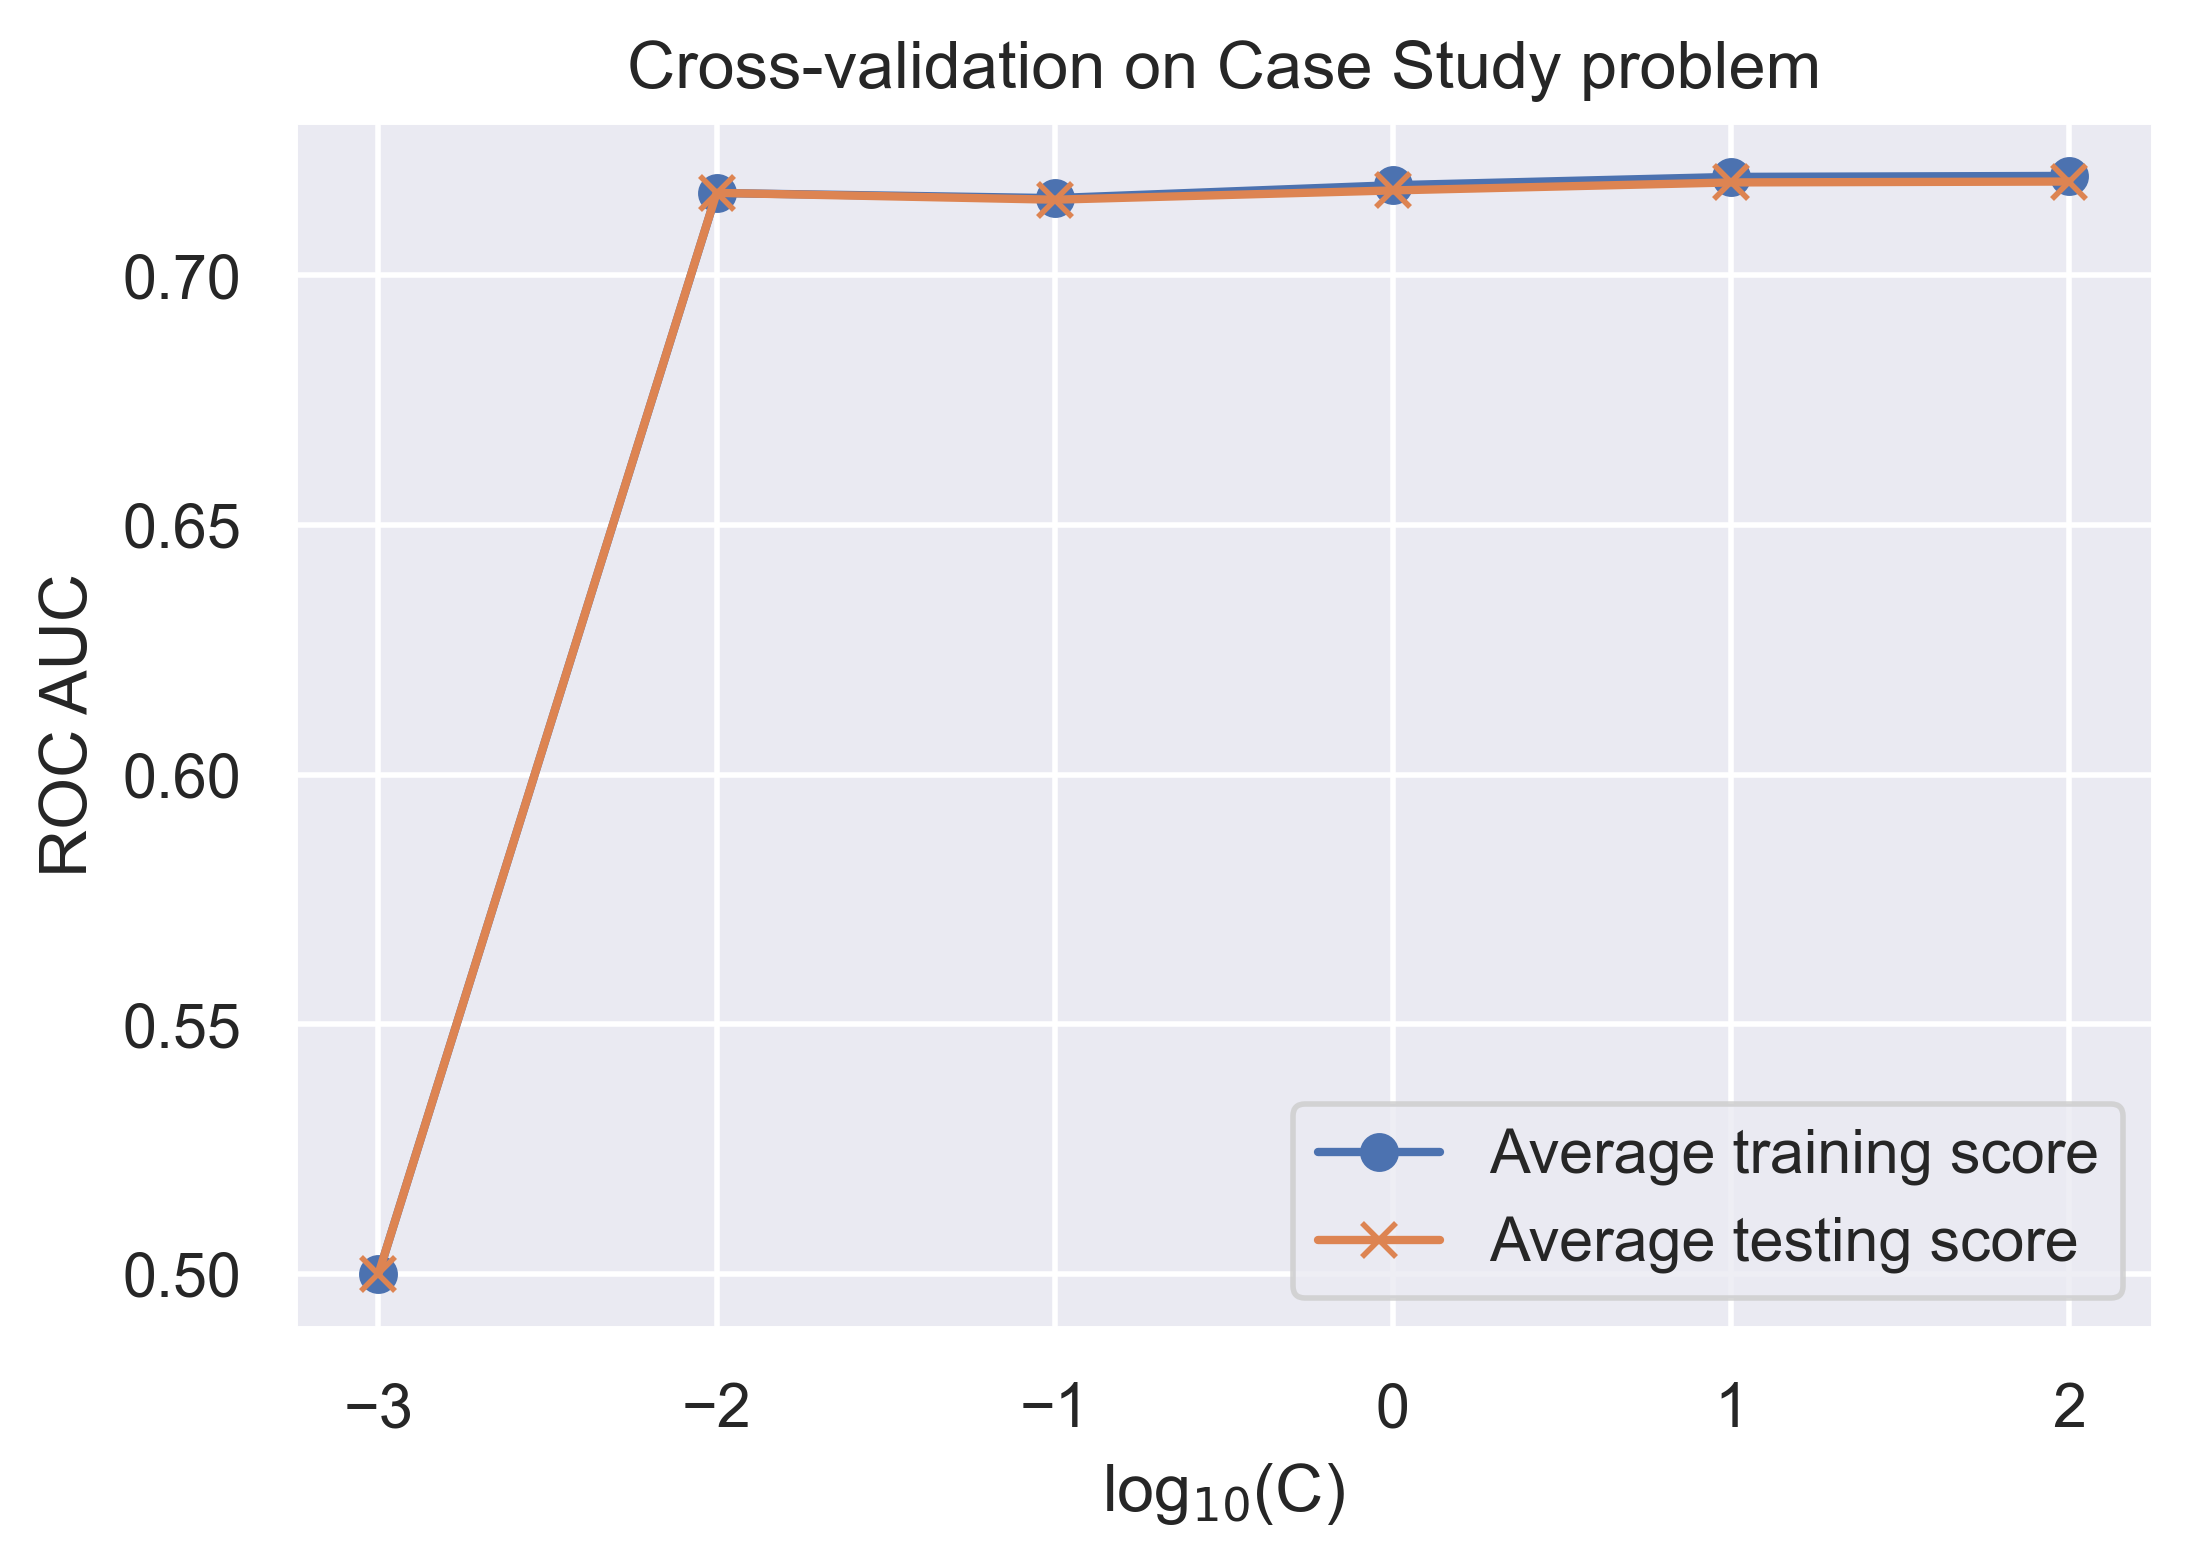

In [64]:
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross-validation on Case Study problem')

Regularization does not impart much benefit here. It appears there is no overfitting going on. We may, however, be underfitting.

## Engineering interaction features

In [67]:
make_interactions = PolynomialFeatures(degree=2,
                                       interaction_only=True,
                                       include_bias=False)
X_interact = make_interactions.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_interact, 
                                                    df['default payment next month'].values,
                                                    test_size=0.2, random_state=24)
print(X_train.shape)
print(X_test.shape)

(21331, 153)
(5333, 153)


We get 153 features, which is 17 choose 2. We are choosing all possible combinations of 2 features to interact from the original 17 features.

In [68]:
%%time
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(k_folds, 
                                                                         C_vals, 
                                                                         scale_lr_pipeline,
                                                                         X_train, y_train)

/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Done with C = 100.0


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Done with C = 10.0


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001
CPU times: user 4min 47s, sys: 74.9 ms, total: 4min 47s
Wall time: 4min 47s


Text(0.5, 1.0, 'Cross-validation on Case Study problem')

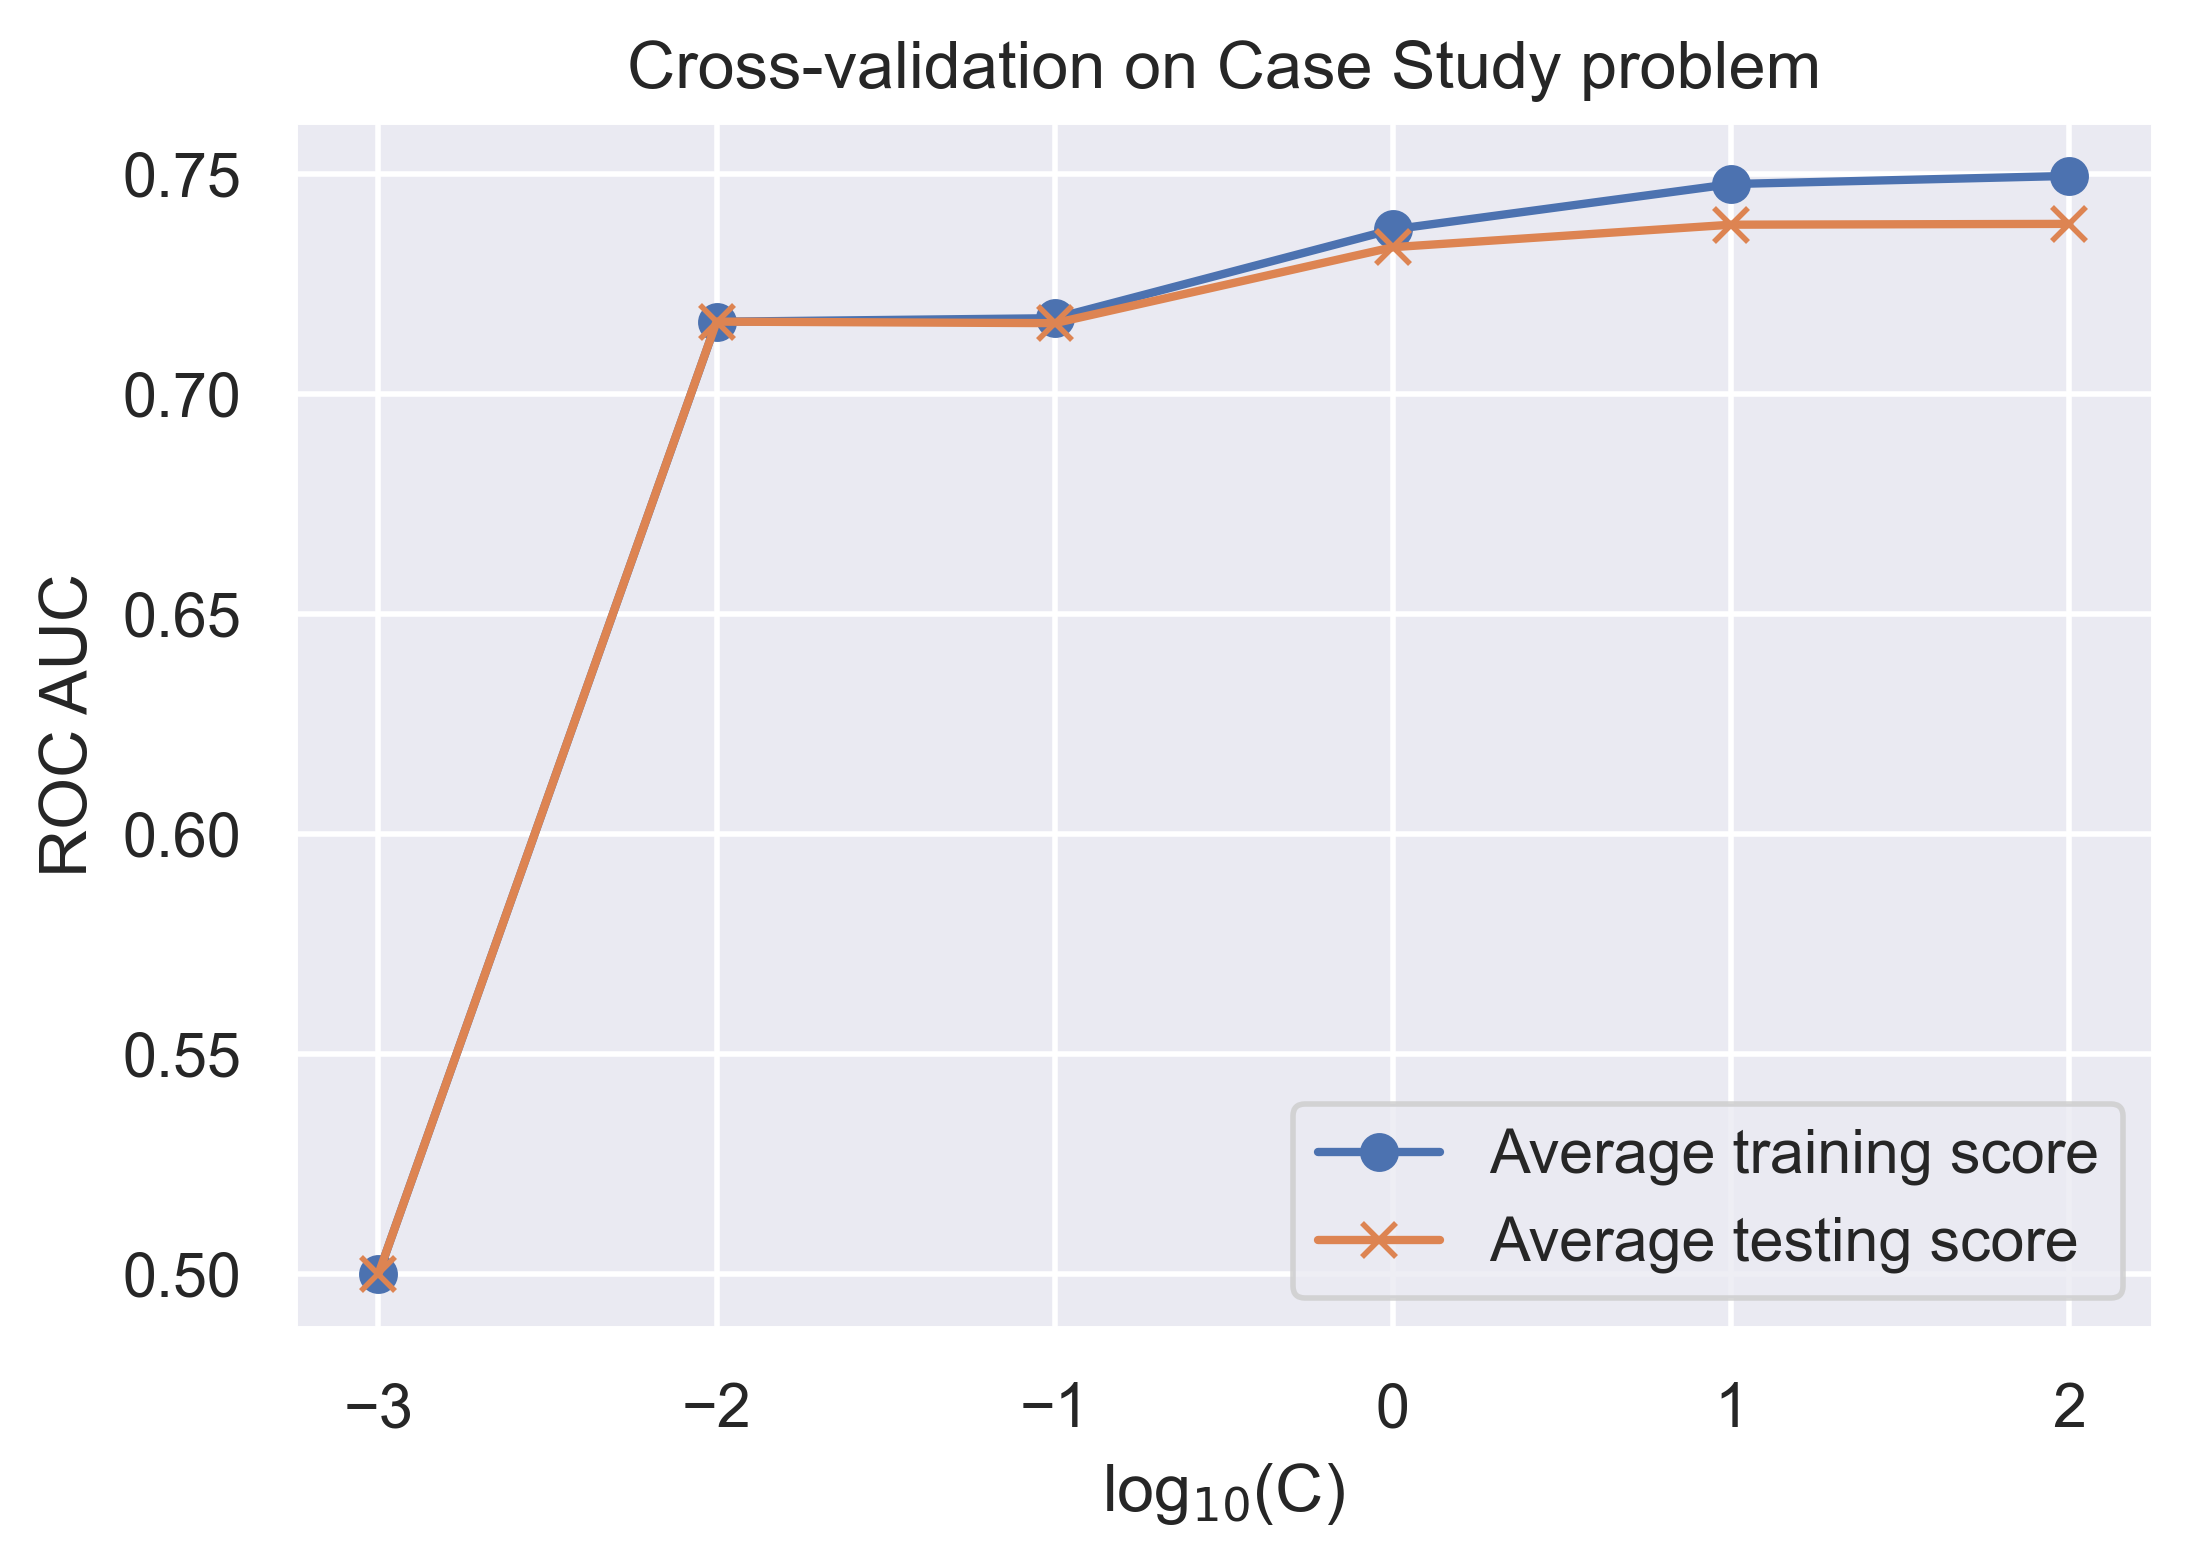

In [69]:
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross-validation on Case Study problem')

Adding interaction feature improved cross-validation performance.